## Test the transform class
- my_scripts/test_flic_dataset.py
- Data preprocessing and transforming
- Using ground truth coordinates of joints to defined bounding box
- Add padding and noise to bounding box and crop images
- Resize the cropped images to 220 x 220
- Normalize the images in each channel, i.e. RGB

In [1]:
# A bit of setup
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Set global variables
data_dir = 'data/FLIC-full' # store image 
train_fn = '%s/train_joints.csv' % data_dir # store corrdinates of joints for training data
train_dl = np.array([l.strip() for l in open(train_fn).readlines()])
N_train = train_dl.shape[0]
print 'Number of training data', N_train

Number of training data 17380


In [12]:
# Choose num_test images from traning set
from my_scripts.transform import Transform
from my_scripts.test_flic_dataset import draw_joints
num_test = 3
num_bounding_box = 5
trans_tests = train_dl[np.random.choice(N_train, num_test)]
# transfrom parameters
pad_inf = 1 # infimum scale
pad_sup = 1.5 # supremum scale
size = 150 # resize size
shift = 3 # radomly shift the bounding box
lcn = True # local contrast normalization
num_joints = 7
result_dir = 'test_results'
trans = Transform(pad_inf,
                  pad_sup,
                  size=size, 
                  shift=shift, 
                  lcn=lcn)

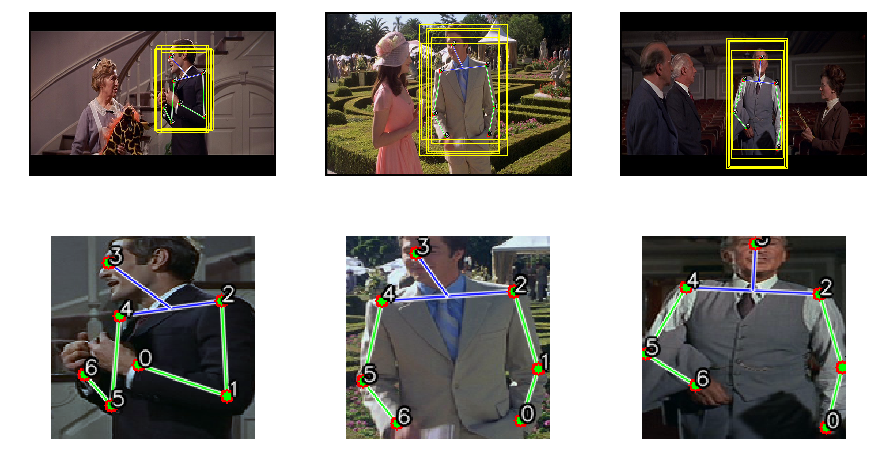

In [13]:
# plot the images
ori_imgs = np.zeros((num_test, 480, 720, 3))
ori_labels = np.zeros((num_test, num_joints * 2))
tran_imgs = np.zeros((num_test, size, size, 3))
tran_labels = np.zeros((num_test, num_joints * 2))
bound_box_params = [] 

for i, x in enumerate(trans_tests):
    x = x.strip().split(',')
    img_file_name = '%s/images/%s' % (data_dir, x[0])
    ori_joints = np.array([int(float(p)) for p in x[1:]])
    ori_img = cv.imread(img_file_name)
    # draw joints
    draw_ori_joints = zip(ori_joints[0::2], ori_joints[1::2])
    ori_img_joints = draw_joints(ori_img.copy(), draw_ori_joints)
    
    # get bounding box
    for j in xrange(num_bounding_box):
        trans._img = ori_img
        trans._joints = ori_joints
        x, y, w, h = trans.crop()
        # draw bouding box
        cv.rectangle(ori_img_joints, (x, y), (x + w, y+h), (0, 255, 255), thickness=2)
        
    ori_imgs[i] = ori_img_joints
    # draw bounding box
    
    # tranformation
    tran_img, tran_joints = trans.transform(img_file_name, ori_img.copy(), ori_joints.copy())
    tran_img, tran_joints = trans.revert(tran_img, tran_joints)
    draw_tran_joints = [tuple(p) for p in tran_joints] # must tuple in opencv
    tran_imgs[i] = draw_joints(tran_img.copy(), draw_tran_joints)
#     tran_imgs[i] = tran_img
for y in xrange(2):
    for i in xrange(num_test):
        plt_idx = y * num_test + i + 1
        plt.subplot(2, num_test, plt_idx)
        if y == 0:
            b,g,r = cv.split(ori_imgs[i])       # get b,g,r
        else:
            b,g,r = cv.split(tran_imgs[i])
        rgb_img = cv.merge([r,g,b])   
        plt.imshow(rgb_img.astype('uint8'))
        plt.axis('off')
plt.show()